# 2CSSID-TP08. Régularisation et sélection d'attributs

Dans ce TP, nous allons voir l'effet de la régularisation et la sélaction d'attributs sur l'apprentissage.
Premierement, nous allons implémenter les deux fonctions de régularisation L1 et L2, ainsi que la méthode de filtrage ANOVA.
Ensuite, nous allons tester l'effet de ces techniques sur la performance en utilisant plusieurs métriques.

- **Binôme 01** : Boukacem Younes
- **Binôme 02** : Benouaklil Hodhaifa
- **Groupe** : **I wonder what group are you! There are many.**

In [1]:
import matplotlib
import numpy             as np 
import pandas            as pd 
import matplotlib.pyplot as plt 
from matplotlib      import colors 
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('1.24.3', '2.0.3', '3.7.2')

In [2]:
from typing import Tuple, List, Dict, Callable


## I. Réalisation des algorithmes

Dans cette partie, nous allons implémenter deux fonctions de régularisation et une fonction de filtrage. 
La régularisation sera appliquée sur la régression logistique binaire dont le code est fourni ici.

In [3]:
# Le code de la régression logistique 
# Ne modifier pas ceci
# これをいじると死ぬよ

# Somme pondérée des caractéristiques
def zf(X: np.ndarray, theta: np.ndarray) -> np.ndarray:
    return np.dot(X, theta)

# Transformation d'une valeur à une probabilité
def sg(Z: np.ndarray) -> np.ndarray:
    return  1 / (1 + np.exp(-Z))

# probabilité d'un échantillons
def hf(X: np.ndarray, theta: np.ndarray) -> np.ndarray:
    return sg(zf(X, theta))

# Fonction objective
# utilisation d'un petit nombre pour éviter log(0)
def BCE(Y: np.ndarray, H: np.ndarray, e: float=1e-8) -> float: 
    return - np.mean(Y * np.log(H) + (1-Y) * np.log(1-H))  

# Fonction des gradients
def dBCE(X: np.ndarray, Y: np.ndarray, H: np.ndarray) -> np.ndarray:
    return  np.dot(X.T, H-Y)/X.shape[0]

# Fonction de mise à jour des paramètres
def majTheta(Theta: np.ndarray, Gradient: np.ndarray, alpha: np.ndarray) -> np.ndarray: 
    return Theta - alpha * Gradient


def normaliser(X: np.ndarray, mean: np.ndarray=None, std: np.ndarray=None) -> np.ndarray: 
    if (mean is None) or (std is None): 
        mean = np.mean(X, axis=0)
        std  = np.std(X, axis=0)
    X_norm = np.where(std==0, X, (X - mean)/std)
    return X_norm, mean, std

def preparer(X: np.ndarray, norm: np.ndarray=True, 
             const: np.ndarray=True, mean: np.ndarray=None, std: np.ndarray=None) -> np.ndarray: 
    X_pre = X.copy()
    if norm: 
        X_pre, mean, std = normaliser(X_pre,mean=mean, std=std)
    if const:
        X_pre = np.append(np.ones((X_pre.shape[0],1)), X_pre ,axis=1)
    return X_pre, mean, std

def generer_zeros_1(nbr: int) -> np.ndarray:
    return np.zeros(nbr)

def generer_uns_1(nbr: int) -> np.ndarray:
    return np.ones(nbr)

### I.1.  Régularisation L2 (Ridge)


#### I.2.1. Fonction du coût de la régularisation L2

La fonction du coût de la régularisation **L2** est calculée somme : 

$$J_{L2}(\theta) = \frac{\lambda }{2M} \sum\limits_{j=1}^{N} \theta_j^2$$

- **M** : nombre des échantiollons (observations)
- **N** : nombre des caractéristiques


**Remarque** Dans les énoncés, la régularisation n'est pas divisée par le nombre des échantillons $M$. Mais, en pratique, on la divise. [Voici des réponses sur stackexchange](https://stats.stackexchange.com/questions/287920/regularisation-why-multiply-by-1-2m) expliquant pourquoi.

In [8]:
# TODO: Coût L2
# Theta0 est le premier element; il ne doit pas etre calcule dans l'erreur
def J_L2(Theta: np.ndarray, M: int, Lambda: float=0.) -> float:
    return (Lambda/(2*M)) * np.dot(Theta[1:], Theta[1:])

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (0.0, 0.0005050000000000001)
#---------------------------------------------------------------------

Theta_t = np.array([1, 0.01, 0.1]) # Theta avec le premier élément pour le biais


J_L2(Theta_t, 4), J_L2(Theta_t, 4, Lambda=.4)

(0.0, 0.0005050000000000001)

#### 1.2.2. Gradients de la régularisation L2

La fonction des gradients de la régularisation **L2** est définie comme suit :
 
$$\frac{\partial J_{L2}(\theta)}{\partial \theta_j} = \frac{\lambda }{M} \theta_j \text{ si } j > 0$$

$$\frac{\partial J_{L2}(\theta)}{\partial \theta_0} = 0$$

- **X** : matrice (échantillons X caractéristiques)
- **Y** : vecteur des sorties réelles (échantillons)
- **H** : vecteur des estimations (échantillons)
- **M** : nombre des échantillons


In [19]:
# TODO: Gradient L2
# Theta0 est le premier element; sont gradient est 0
def dJ_L2(Theta: np.ndarray, M: int, Lambda: float=0.) -> np.ndarray:
    res = Theta.copy()
    res[0] = 0
    return (Lambda/M) * res


#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (array([0., 0., 0.]), array([0.   , 0.001, 0.01 ]))
#---------------------------------------------------------------------

Theta_t = np.array([1, 0.01, 0.1]) # Theta avec le premier élément pour le biais

dJ_L2(Theta_t, 4), dJ_L2(Theta_t, 4, Lambda=0.4)

(array([0., 0., 0.]), array([0.   , 0.001, 0.01 ]))

### I.2.  Régularisation L1 (Lasso)

#### I.2.1. Fonction du coût de la régularisation L1

La fonction du coût de la régularisation **L1** sur cette fonction, on aura : 

$$J_{L1}(\theta) = \frac{\lambda}{M} \sum\limits_{j=1}^{N} |\theta_j|$$

- **M** : nombre des échantiollons (observations)
- **N** : nombre des caractéristiques

In [12]:
# TODO: Coût L1
# Theta0 est le premier element; il ne doit pas etre calcule dans l'erreur
def J_L1(Theta: np.ndarray, M: int, Lambda: float=0.) -> float:
    return (Lambda/M) * np.sum(np.abs(Theta[1:]))

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (0.0, 0.011000000000000001)
#---------------------------------------------------------------------

Theta_t = np.array([1, 0.01, 0.1]) # Theta avec le premier élément pour le biais

J_L1(Theta_t, 4), J_L1(Theta_t, 4, Lambda=.4)

(0.0, 0.011000000000000001)

#### I.2.2. Mise à jour des paramètres 

La dérivée de $L1$ est :
$$\frac{\partial L1}{\partial \theta_j} = \frac{\partial \frac{\lambda }{M} \sum\limits_{j=1}^{N} |\theta_j|}{\partial \theta_j} = \frac{\lambda }{M} \frac{\theta_j}{|\theta_j|}$$

Il est clair que le gradient n'est pas définit dans le cas $\theta_j = 0$. 
En appliquant [le sous-différentiel](https://fr.wikipedia.org/wiki/Sous-diff%C3%A9rentiel), nous aurons : 
$$
\frac{\partial L1}{\partial \theta_j} = 
\begin{cases}
-\frac{\lambda}{M} & \text{si } \theta_j < 0 \\
0 & \text{si } \theta_j = 0 \\
\frac{\lambda}{M} & \text{si } \theta_j > 0 \\
\end{cases}
$$

Nous ne pouvons pas utiliser la descente du gradient pour résoudre ça. 
Nous allons utiliser un algorithme de descente du gradient approximative, qui s'appelle **Iterative soft-thresholding algorithm (ISTA)**. 
$$prox(\theta) = S_{\lambda}(\theta) = 
\begin{cases}
\theta_j + \lambda & \text{si } \theta_j < - \lambda \\
0 & \text{si } -\lambda \le \theta_j \le \lambda \\
\theta_j - \lambda & \text{si } \theta_j > \lambda \\
\end{cases}
$$

**Vous devez implémenter cette fonction**

Les thétas sont mises à jour comme suite : 
$$ \theta = S_{\lambda}(\theta - \frac{\partial J_0}{\partial \theta})$$
Où, $J_0$ est la fonction du coût sans régularisation

Source : [Ryan Tibshirani (2015), Lecture 08: Proximal Gradient Descent](https://www.stat.cmu.edu/~ryantibs/convexopt-S15/scribes/08-prox-grad-scribed.pdf)

In [13]:
# TODO: Soft-thresholding : prox(theta)
# P.S. Ce n'ai pas la peine de devider Lambda sur M
# puisque nous le devisons avant d'appeler cette fonction
# Theta0 est le premier element; il ne doit pas etre mis a jour
# son soft-thresholding est lui-meme
# si vous aurez [ 0.4 , -0.15,  0.  ] dans le resultat ca veut dire vous
# etes en train d'appliquer S sur Theta0
def S(Theta: np.ndarray, Lambda: float) -> np.ndarray:
    res = Theta.copy() 
    for theta, i in zip(Theta[1:], range(1, len(Theta))):
        if(theta < -Lambda):
            res[i] = theta + Lambda
        elif(theta > Lambda):
            res[i] = theta - Lambda
        else:
            res[i] = 0
    return res

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : array([ 0.5 , -0.15,  0.  ])
#---------------------------------------------------------------------


Theta_t = np.array([0.5, -0.25, 0.05])

S(Theta_t, 0.1)

array([ 0.5 , -0.15,  0.  ])

### I.3. Régression avec réglularisation

**Rien à programmer ici**


In [20]:
def descente(X: np.ndarray, Y: np.ndarray, Theta: np.ndarray, approx: Callable=None, it_max: int=100, alpha: float=0.1, Lambda: float=0.): 

    M = len(Y)
    
    if approx :
        def maj(Theta, J, dJ):
            J    += J_L1(Theta, M, Lambda=Lambda)
            Theta = majTheta(Theta, dJ, alpha)
            Theta = S(Theta, Lambda/M) # Lamdba doit être divisé sur le nombre des échantillons
            return J, Theta
    else:
        def maj(Theta, J, dJ):
            J    += J_L2(Theta, M, Lambda=Lambda)
            dJ   += dJ_L2(Theta, M, Lambda=Lambda)
            Theta = majTheta(Theta, dJ, alpha)
            return J, Theta
            
    couts  = []
    Thetas = []
    
    # pour ne pas modifier le contenu de Theta en entrée
    #
    # Si cette ligne est modifiee, Theta va etre mis a jours
    # plusieurs fois, ce qui va causer la formation d'un trou noire 
    # qui va envoyer votre processor en arriere dans le temps 
    # a l'instant avant la mise a jours des paramettres 
    Theta  = Theta.copy()
    
    # ici, on boucle jusqu'à arriver aux maximum des itérations
    for it in range(it_max):
        H        = hf(X, Theta)
        J        = BCE(Y, H)
        dJ       = dBCE(X, Y, H)
        J, Theta = maj(Theta, J, dJ)
        couts.append(J)
        Thetas.append(Theta.copy())
    
    return Thetas, couts

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array([ 0.94839532, -0.56840255,  1.2813832 ]),
#  array([ 0.46328109, -0.15750488,  0.        ]),
#  array([ 0.93431089, -0.53451115,  1.03711393]))
#
#---------------------------------------------------------------------

X_t = np.array([
    [1, 1, 0.2],
    [1, 2, 0.1],
    [1, 3, 0.4],
    [1, 4, 0.3]
])

Theta_t = np.array([1., 1., 1.])
Y_t     = np.array([1, 0, 1, 0])

# pas de régularisation : Lambda = 0
Theta_P, J_P = descente(X_t, Y_t, Theta_t)
# régularisation L1 : approximation avec lambda
Theta_1, J_1 = descente(X_t, Y_t, Theta_t, approx=S, Lambda=0.1)
# régularisation L2 : lambda sans approximation
Theta_2, J_2 = descente(X_t, Y_t, Theta_t, Lambda=0.1)

Theta_P[-1], Theta_1[-1], Theta_2[-1]


(array([ 0.94839532, -0.56840255,  1.2813832 ]),
 array([ 0.46328109, -0.15750488,  0.        ]),
 array([ 0.93431089, -0.53451115,  1.03711393]))

In [21]:
class RegLogReg(object): # Régression logistique régularisée
    
    # par défaut : pas de régularisation
    def __init__(self, nbr_iter: int=100, 
                 alpha: float=.01, Lambda: float=1.0, norm: bool=True, const: bool=True, reg: str=None): 
        self.nbr_iter = nbr_iter
        self.alpha    = alpha
        self.norm     = norm
        self.const    = const
        self.approx   = None
        self.Lambda   = Lambda
        if reg == "l1":
            self.approx = S
        elif reg != "l2":
            self.Lambda = 0.
    
    def entrainer(self, X: np.ndarray, Y: np.ndarray): 
        X_pre, self.mean, self.std = preparer(X, norm=self.norm, const=self.const)
        Theta = generer_uns_1(X_pre.shape[1])#
        self.Thetas, self.couts = descente(X_pre, Y, Theta, 
                                          approx=self.approx, 
                                          it_max=self.nbr_iter, 
                                          alpha =self.alpha, 
                                          Lambda=self.Lambda)
        
    # La prédiction
    # si classes=True elle rend une vecteur de 1 et 0
    # sinon elle rend un vecteur de probabilités
    def predire(self, X: np.ndarray, classes: bool=True, seuil: float=0.5, it: int=-1) -> np.ndarray:
        X_pre, self.mean, self.std = preparer(X, norm=self.norm, const=self.const, mean=self.mean, std=self.std)
        H = hf(X_pre, self.Thetas[it])
        if classes:
            return (H >= seuil).astype(int)
        return H

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array([0.86383643, 0.5273866 , 0.96123235]),
#  array([0.79153709, 0.        , 0.        ]),
#  array([0.8515839 , 0.38351525, 0.7672672 ]),
#  array([0, 0, 1, 1]))
#---------------------------------------------------------------------

X_t = np.array([
    [100, 20],
    [200, 10],
    [300, 40],
    [400, 30]
])

Y_t = np.array([1, 0, 1, 0])

# pas de régularisation
reglog = RegLogReg()
reglog.entrainer(X_t, Y_t)
# régularisation L1
reglog1 = RegLogReg(reg="l1")
reglog1.entrainer(X_t, Y_t)
# régularisation L2
reglog2 = RegLogReg(reg="l2")
reglog2.entrainer(X_t, Y_t)

reglog.Thetas[-1], reglog1.Thetas[-1], reglog2.Thetas[-1], reglog.predire(X_t)

(array([0.86383643, 0.5273866 , 0.96123235]),
 array([0.79241836, 0.        , 0.        ]),
 array([0.8515839 , 0.38351525, 0.7672672 ]),
 array([0, 0, 1, 1]))

### I.4. Filtrage des attributs (ANOVA : Analysis of Variance)

Le nombre des échantillons pour chaque classe est différent. 
Pour cette raison, nous allons implémenter ANOVA for a CRD (COMPLETELY RANDOM DESIGN). 
L'algorithme est expliqué dans [Richard Horsly (2012) COMPLETELY RANDOM DESIGN (CRD)](https://www.ndsu.edu/faculty/horsley/CRD.pdf). 
Pour valider l'implémentation, nous allons utiliser les mêmes données de la page 10.

#### I.4.1. One way F value pour un seul attribue

Pour un attribut donné ($A$), l'ensemble des valeurs des échantillons sera divisé sur $N$ ensembles, où $N$ est le nombre des classes. 

$$CF = \frac{(\sum_{ij} A_{ij})^2}{\sum_j |A_j|} $$
Où $\sum_{ij} A_{ij}$ est la somme de toutes les valeurs de toutes les classes, 
$\sum_j |A_j|$ est le nombre total des échantillons (de toutes les classes)

$$ TotalSS = \sum_{ij} A_{ij}^2 - CF$$
Où $\sum_{ij} A_{ij}^2$ est les somme des carrées de toutes les valeurs

$$ TreatmentSS = \sum_j \frac{(\sum_{i} A_{ij})^2}{|A_j|} - CF$$
Où $\sum_{i} A_{ij}$ est la somme des valeurs de la classe $j$ et $|A_j|$ est le nombre des éléments dans la classe $j$

$$ ErrorSS = TotalSS - TreatmentSS $$


In [41]:
# TODO: One-way ANOVA pour un attribut
def f_oneway(A: np.ndarray) -> float: 
    # A est une liste de N listes où N est le nombre des classes
    # Ces listes n'ont pas la même taille
    nbrs         = np.array([len(a) for a in A]) # nombre des échantillons de chaque classe
    sommes       = np.array([np.sum(a) for a in A]) # somme des valeurs de chaque classe
    sommes_caree = np.sum([np.sum(np.array(a)**2) for a in A]) # somme des valeurs carrées de toutes les valeurs
    
    # Compléter ici
    #====================================
    CF          = (np.sum(sommes))**2 / np.sum(nbrs)
    TotalSS     = np.sum(sommes_caree) - CF
    TreatmentSS = np.sum(sommes**2 / nbrs) - CF
    ErrorSS     = TotalSS - TreatmentSS
    #====================================
    
    MSB = TreatmentSS / (len(A) - 1) 
    MSW =  ErrorSS/(nbrs.sum() - len(A))
    return MSB/MSW


#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 6.418894830659841 (voir page 11 step 6)
#---------------------------------------------------------------------

AA = [[2., 2.2, 1.8, 2.3, 1.7], # elements de la classe A
      [1.7, 1.9, 1.5],          # elements de la classe B
      [2., 2.4, 2.7, 2.5, 2.4], # elements de la classe C
      [2.1, 2.2, 2.2, 1.9]]     # elements de la classe D

f_oneway(AA)

6.418894830659841

#### I.4.2. One way F value pour tous les attribues

**Rien à programmer ou analyser ici**

Ici, nous allons calculer ANOVA pour chaque attribut. 
Les attributs avec des grandes valeurs ANOVA sont meilleurs. 

In [42]:
def anova_f(X: np.ndarray, Y: np.ndarray) -> np.ndarray: 
    
    C = np.unique(Y)
    F = []
    for j in range(X.shape[1]): 
        A = X[:, j]
        F.append(f_oneway([A[Y==c] for c in np.unique(Y)]))
    return np.array(F)


#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array([  6.41889483,   0.40595497, 105.2745098 ]),
#  array([  6.41889483,   0.40595497, 105.2745098 ]))
#---------------------------------------------------------------------

X_t = np.array(
    [[2. , 1. , 1. ],
     [2.2, 2. , 1. ],
     [1.8, 3. , 1. ],
     [2.3, 4. , 1. ],
     [1.7, 5. , 2. ],
     [1.7, 1. , 2. ],
     [1.9, 2. , 2. ],
     [1.5, 3. , 2. ],
     [2. , 1. , 3. ],
     [2.4, 2. , 3. ],
     [2.7, 3. , 3. ],
     [2.5, 4. , 3. ],
     [2.4, 5. , 3. ],
     [2.1, 1. , 4. ],
     [2.2, 2. , 4. ],
     [2.2, 3. , 4. ],
     [1.9, 4. , 4. ]])

Y_t = np.array(["A", "A", "A", "A", "A", "B", "B", "B", "C", "C", "C", "C", "C", "D", "D", "D", "D"])

# pour valider notre implémentation, nous allons utiliser f_classif de scikit-learn 
# https://github.com/scikit-learn/scikit-learn/blob/95d4f0841d57e8b5f6b2a570312e9d832e69debc/sklearn/feature_selection/_univariate_selection.py#L42
from sklearn.feature_selection import f_classif
f_sklearn, a = f_classif(X_t, Y_t)
f_notre      = anova_f  (X_t, Y_t)

# la première liste est celle de scikit-learn et la deuxième est la notre
f_sklearn, f_notre

(array([  6.41889483,   0.40595497, 105.2745098 ]),
 array([  6.41889483,   0.40595497, 105.2745098 ]))

## II. Application et analyse

Nous allons utiliser le dataset [Diabetics prediction using logistic regression](https://www.kaggle.com/kandij/diabetes-dataset). 

In [43]:
diabetes   = pd.read_csv("data/diabetes2.csv") 
X_diabetes = diabetes.iloc[:, :-1].values  
Y_diabetes = diabetes.iloc[:,  -1].values

# Cette configuration est mise en place comme ceci exprès
# C'est pour tester le cas où la régression est difavorisée
NBR_TEST = 240
# Supposant que les 30% premières lignes sont pour le test et le reste pour l'entraînement
X_test  = X_diabetes[-NBR_TEST:, :] # 30% ou plus
Y_test  = Y_diabetes[-NBR_TEST:   ]

X_train = X_diabetes[:-NBR_TEST, :] 
Y_train = Y_diabetes[:-NBR_TEST   ]

diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### II.1. Régularisation

Nous avons entrainé 3 modèles :
- **reglog** : régression logistique sans régularisation
- **reglog_l1** : régression logistique avec régularisation L1
- **reglog_l2** : régression logistique avec régularisation L2

Nous avons testé ces modèles en utilisant deux datasets (avec la métrique F1 dans chaque itération) :
- **entrainement** : pour tester la convergence (fitting)
- **test** : pour tester la généralisation

Afin de capturer les F1 scores et les paramètres, nous avons entrainé chaque modèle avec une seule itération et utiliser une boucle globale pour contrôler les traitements de chaque itération. Pour continuer l'entrainement à partir des thétas précédents, nous avons activé l'option **warm_start**. Ceci va générer des graphiques non lisses (puisque l'algorithme d'optimisation est lancé à chaque itération).

#### II.1.1.  Convergence et généralisation sans et avec régularisation par itérations

Ici, nous supposons que l'algorithme a convergé lorsqu'il atteint le maximum de F1 score dans l'antrainement (normalement, il doit sortir s'il y a une chutte de F1 score et retourne les thétats les plus optimaux). Donc, au delà du point de la convergence, nous avons continuer l'itération pour voir ce qui va se passer. 


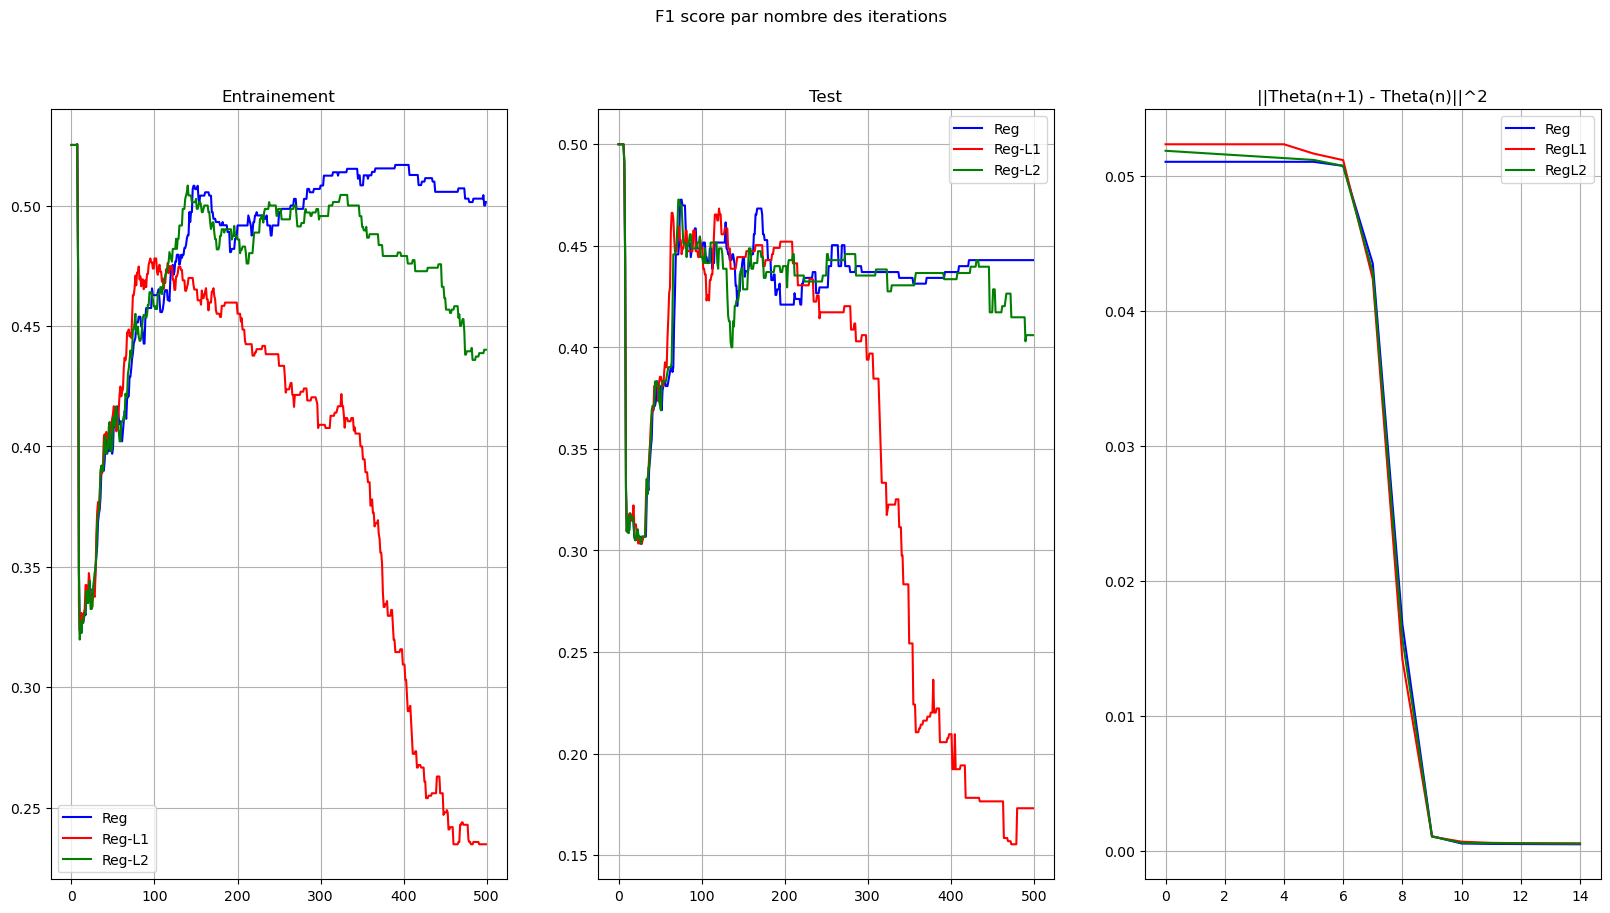

In [57]:
import warnings
from sklearn.exceptions   import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics      import f1_score
warnings.filterwarnings("ignore", category=ConvergenceWarning)

MAX_IT     = 500
CC         = 0.002
COEF_      = np.array([[1.] * X_train.shape[1]])
INTERCEPT_ = np.array([1.])

reglog = LogisticRegression(penalty=None, solver="saga", max_iter=1, warm_start=True, random_state=0)
reglog.coef_      = COEF_.copy()
reglog.intercept_ = INTERCEPT_.copy()

reglog_l1 = LogisticRegression(penalty='l1', solver="saga", max_iter=1, warm_start=True, random_state=0, C=CC)
reglog_l1.coef_      = COEF_.copy()
reglog_l1.intercept_ = INTERCEPT_.copy()

reglog_l2 = LogisticRegression(penalty='l2', solver="saga", max_iter=1, warm_start=True, random_state=0, C=CC)
reglog_l2.coef_      = COEF_.copy()
reglog_l2.intercept_ = INTERCEPT_.copy()

coefs         = []
coefs0        = []
f1train       = []
f1test        = []

coefs_ridge   = []
coefs0_ridge  = []
f1train_ridge = []
f1test_ridge  = []

coefs_lasso   = []
coefs0_lasso  = []
f1train_lasso = []
f1test_lasso  = []

for it in range(MAX_IT):
    reglog.fit(X_train, Y_train)
    coefs.append(reglog.coef_.flatten().tolist())
    coefs0.append(reglog.intercept_[0])
    f1train.append(f1_score(Y_train, reglog.predict(X_train)))
    f1test.append(f1_score(Y_test, reglog.predict(X_test)))
    
    reglog_l1.fit(X_train, Y_train)
    coefs_lasso.append(reglog_l1.coef_.flatten().tolist())
    coefs0_lasso.append(reglog_l1.intercept_[0])
    f1train_lasso.append(f1_score(Y_train, reglog_l1.predict(X_train)))
    f1test_lasso.append(f1_score(Y_test, reglog_l1.predict(X_test)))
    
    reglog_l2.fit(X_train, Y_train)
    coefs_ridge.append(reglog_l2.coef_.flatten().tolist())
    coefs0_ridge.append(reglog_l2.intercept_[0])
    f1train_ridge.append(f1_score(Y_train, reglog_l2.predict(X_train)))
    f1test_ridge.append(f1_score(Y_test, reglog_l2.predict(X_test)))


coefs       = np.array(coefs)
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.suptitle("F1 score par nombre des iterations")
fig.set_figwidth(20)
fig.set_figheight(10)

ax1.plot(range(MAX_IT), f1train, color="blue", label="Reg")
ax1.plot(range(MAX_IT), f1train_lasso, color="red", label="Reg-L1")
ax1.plot(range(MAX_IT), f1train_ridge, color="green", label="Reg-L2")
ax1.legend()
ax1.set_title("Entrainement")
ax1.grid()

ax2.plot(range(MAX_IT), f1test, color="blue", label="Reg")
ax2.plot(range(MAX_IT), f1test_lasso, color="red", label="Reg-L1")
ax2.plot(range(MAX_IT), f1test_ridge, color="green", label="Reg-L2")
ax2.legend()
ax2.set_title("Test")
ax2.grid()

error_lasso = [np.dot(a - b, a-b) for a, b in zip(coefs_lasso[1:], coefs_lasso[:-1])]
error_ridge = [np.dot(a - b, a-b) for a, b in zip(coefs_ridge[1:], coefs_ridge[:-1])]
error = [np.dot(a - b, a-b) for a, b in zip(coefs[1:], coefs[:-1])]
ax3.plot(range(15), error[:15], color="blue", label="Reg")
ax3.plot(range(15), error_lasso[:15], color="red", label="RegL1")
ax3.plot(range(15), error_ridge[:15], color="green", label="RegL2")
ax3.legend()
ax3.grid()
ax3.set_title("||Theta(n+1) - Theta(n)||^2")


plt.show()

**TODO: Analyser les résultats**

- Que remarquez-vous ?
- Analyser les cas de convergence (qui converge plus rappidement, avec quel prix (quel est le gain ou la perte)) en précisant dans ce cas l'intérêt de la régularisation. 
- Pourquoi les modèles avec régularisation perdent-ils de performance avec plus d'térations ?

**Réponse**

- On remarque que les régularisations L1 et L2 n'ont pas améliorer les résultats de modèle sans régularisation, avec le peak de F1-scrore de L1 plus faible que celui de L2.
- L1 converge plus rapidement, avec une perte dans la performance du modèle (F1-score). En général la regularisation sert a ameliorer la qualité de généralisation du modele, or dans ce cas ce n'est pas le cas donc le seul interet pourrait etre le gain en vitesse de convergence 
- Car en laissant le modele s'entrainer plus longtemps, il va avoir tendance a faire tendre vers 0 certains Theta_j (alors que ce n'est pas forcement des attributs completement non pertinants, seulement à cause de l'aléatoire de l'échantillonage) --> le modele n'apprendra pas aussi bien --> underfitting

#### II.1.2. Convergence des paramètres par itérations

Ici, nous avons afficher les valeurs des paramètres thétas pour chaque itération. 


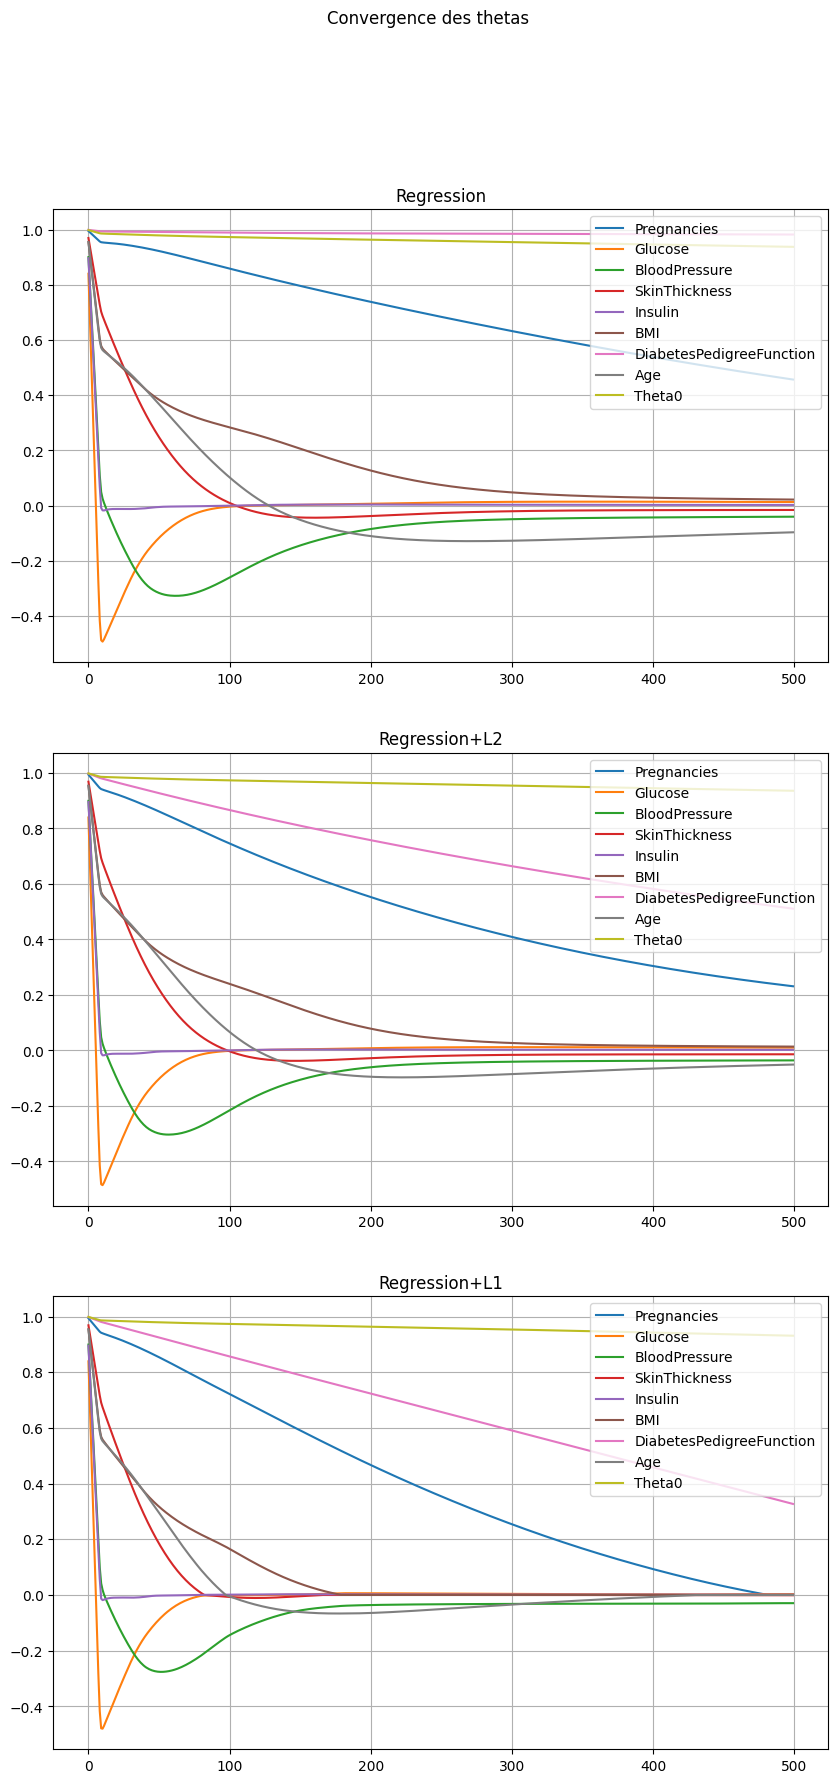

In [14]:
labels = list(diabetes.columns)
labels.pop()
#labels = ["Theta0"] + labels
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.suptitle("Convergence des thetas")
fig.set_figwidth(10)
fig.set_figheight(20)
for i in range(len(labels)): 
    ax1.plot(range(MAX_IT), coefs[:, i], label=labels[i])
    ax3.plot(range(MAX_IT), coefs_lasso[:, i], label=labels[i])
    ax2.plot(range(MAX_IT), coefs_ridge[:, i], label=labels[i])
ax1.plot(range(MAX_IT), coefs0, label="Theta0")
ax2.plot(range(MAX_IT), coefs0_ridge, label="Theta0")
ax3.plot(range(MAX_IT), coefs0_lasso, label="Theta0")
ax1.legend()
ax1.set_title("Regression")
ax1.grid()
ax3.legend()
ax3.set_title("Regression+L1")
ax3.grid()
ax2.legend()
ax2.set_title("Regression+L2")
ax2.grid()

plt.show()

**TODO: Analyser les résultats**

- Que remarquez-vous ?
- Analyser la convergence des valeurs des paramètres entre les trois modèles (pourquoi dans les deux modèles avec régularisation, les valeurs se rapprochent plus de 0, pourquoi il y a des paramètres qui convergent plus rappidement que d'autres)
- Pouvons-nous déduire les attributs jugés importants par le modèle ? Si oui, lesquels ? Si non, pourquoi ?
- Est-ce que la régularisation peut être utilisée comme sélection d'attribut ? Préciser (avec argumentation)

**Réponse**

- On remarque que les parametres des attributs 'Insuline, glucose, blood pressure, skin thickness, BMI' tendent vers 0 pour les 3 modeles, L1 a fait tendre vers 0 les parametres des attributs 'pregnancies, age' et a laissé 'DiabetePedegreFunction, Theta0', tandis que L2 a fait tendre vers 0 les parametres des attributs 'age' et a laissé 'pregnancies, DiabetePedegreFunction, Theta0'
- Analyse:
  - Les valeurs de certains parametres tendent vers 0 dans les modeles avec regularisation car les attributs correspondant à ces parametres ne sont pas pertinants pour la sortie --> augmente le biais du modele et ainsi potentiellement reduire l'overfitting --> meilleure generalisation.
  - Certains parametres converge plus rapidement que d'autres soit à cause de la forte correlation entre certains attributs où la régularisation va éliminer l'effet de ces attributs sauf un représentant de ces derniers, ou bien il y a des attributs qui ont des correlations significativement plus faible que d'autre avec la sortie ce qui les fait tendre plus vite vers 0.
- Oui: 
  - Sans regularisation: DiabetePedegreFunction et pregnencies et age
  - regularisation L2: DiabetePedegreFunction et pregnencies
  - regularisation L1: DiabetePedegreFunction
- oui, car en faisant tendre vers 0 les coefficients correspondant à certains attributs, le modele elimine ces attributs ce qui revient à faire une selection d'attributs où les attributs pertinants sont ceux qui auront garder des coefficients non nuls

### II.2. Sélection d'attributs

Ici, on va utiliser le même dataset précédent sur plusieurs types de sélection d'attributs.

#### II.2.1. Sélection d'attributs par filtrage (Choix ANOVA)

Nous avons extrait les F values ANOVA pour les différents attributs. 


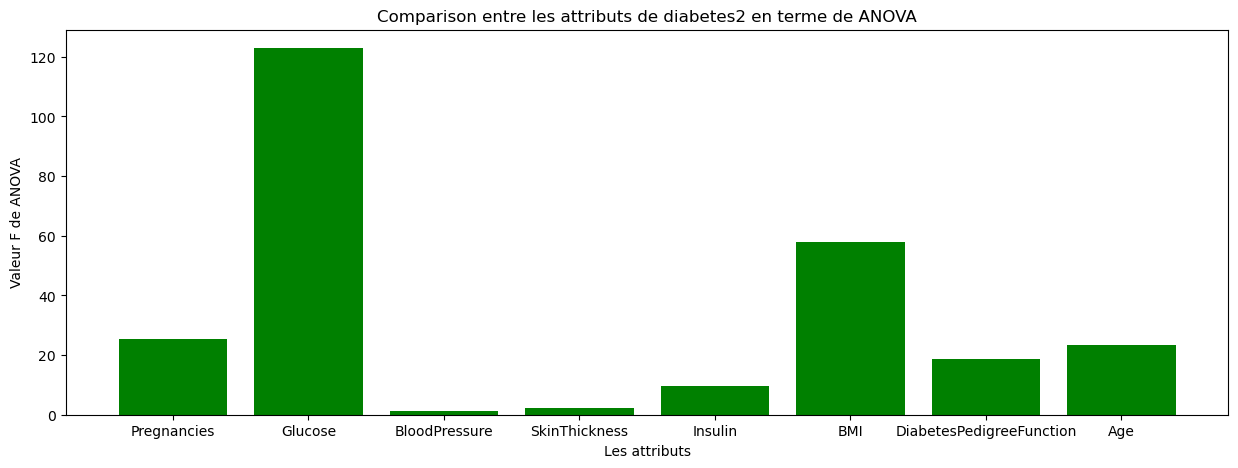

In [61]:
from sklearn.feature_selection import f_classif
f, a = f_classif(X_train, Y_train)

labels_diabetes = list(diabetes.columns[:-1])
x_pos = range(len(f))
plt.figure(figsize=(15,5))
plt.bar(labels_diabetes, f, color="green")
plt.xlabel("Les attributs")
plt.ylabel("Valeur F de ANOVA")
plt.title("Comparison entre les attributs de diabetes2 en terme de ANOVA")

plt.xticks(x_pos, labels_diabetes)

plt.show()


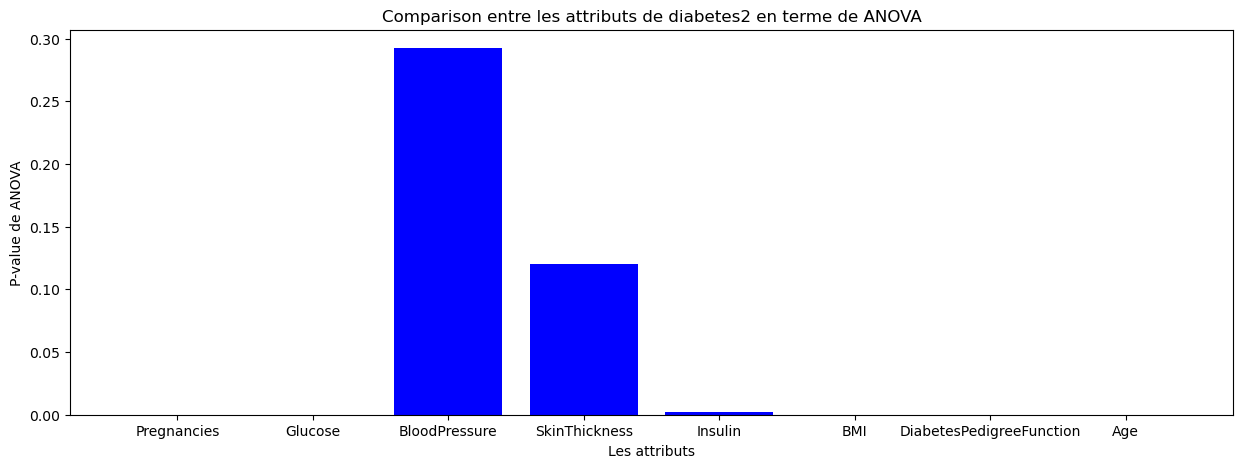

In [63]:
labels_diabetes = list(diabetes.columns[:-1])
x_pos = range(len(a))
plt.figure(figsize=(15,5))
plt.bar(labels_diabetes, a, color="blue")
plt.xlabel("Les attributs")
plt.ylabel("P-value de ANOVA")
plt.title("Comparison entre les attributs de diabetes2 en terme de ANOVA")

plt.xticks(x_pos, labels_diabetes)

plt.show()


**TODO: Analyser les résultats** 

- Quels sont les attributs les plus importants d'après F values ?
- Pourquoi un attribut est considéré comme important dans ANOVA (aspect mathématique et logique : les valeurs de l'attribut et de la prédiction Y) ?
- Pourquoi nous avons utilisé ANOVA et pas Pearson ?

**Réponse**

- ce sont les attributs avec des F value élevées ie des p-values faibles (moins de 5%): glucose, bmi, pregancies et age, DiabetesPedigreeFunction, Insulin.
-  un attribut est considéré comme important dans ANOVA dans le cas ou sa F value est grande <--> p-value petite <--> la probabilité d'obtenir notre dataset sous l'hypothese H0:"les valeurs de l'attribut n'ont pas d'effet sur la sortie Y" est tres faible --> H0 est rejeté donc l'attribut et important
- on a utilisé ANOVA car on est dans le cas ou les attributs sont numeriques et la sortie nominale (Pearson est utilisé  dans le cas attributs numerique sortie numerique)

#### II.2.2. Sélection d'attributs par filtrage (Convergence et performance)

Ici, on va utiliser ANOVA pour pré-sélectionner les caractéristiques qui donnent 50% de variance. On veut comparer la convergence du modèle normal contre celui avec pré-sélection ANOVA.


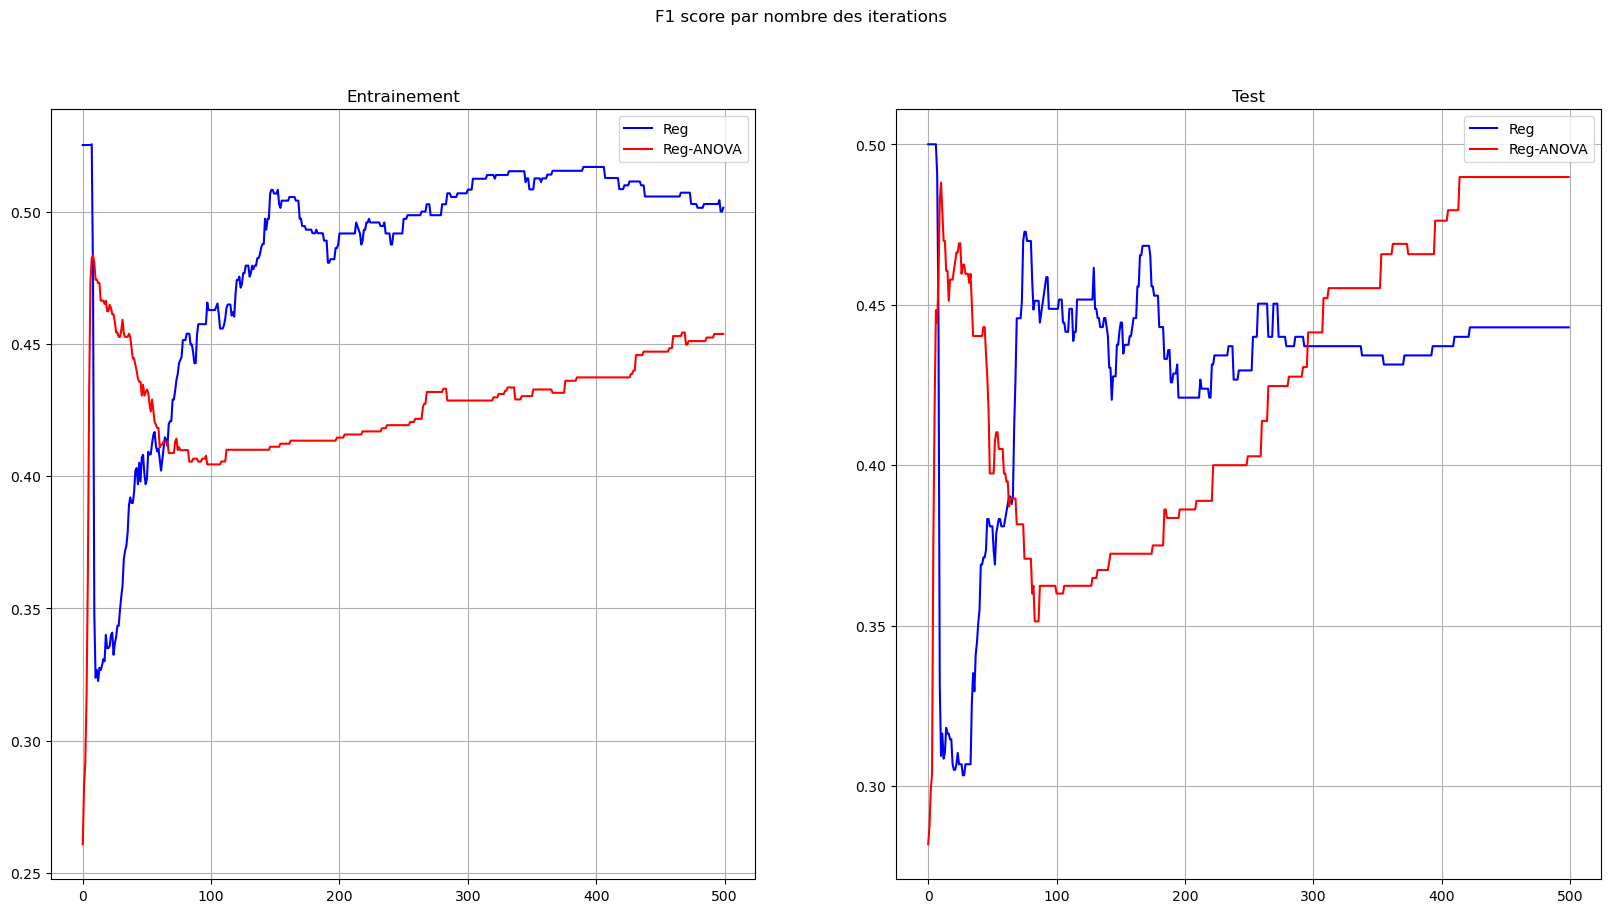

In [67]:
from sklearn.feature_selection import SelectPercentile

selecteur = SelectPercentile(score_func=f_classif, percentile=50)
X_train_new = selecteur.fit_transform(X_train, Y_train)
X_test_new = selecteur.transform(X_test)

reglog_anova = LogisticRegression(penalty=None, solver="saga", max_iter=1, warm_start=True, random_state=0)
reglog_anova.coef_      = np.array([[1.] * X_train_new.shape[1]])
reglog_anova.intercept_ = INTERCEPT_

coefs_anova   = []
coefs0_anova  = []
f1train_anova = []
f1test_anova  = []

for it in range(MAX_IT):
    reglog_anova.fit(X_train_new, Y_train)
    coefs_anova.append(reglog_anova.coef_.flatten().tolist())
    coefs0_anova.append(reglog_anova.intercept_[0])
    f1train_anova.append(f1_score(Y_train, reglog_anova.predict(X_train_new)))
    f1test_anova.append(f1_score(Y_test, reglog_anova.predict(X_test_new)))

coefs_anova = np.array(coefs_anova)

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle("F1 score par nombre des iterations")
fig.set_figwidth(20)
fig.set_figheight(10)

ax1.plot(range(MAX_IT), f1train, color="blue", label="Reg")
ax1.plot(range(MAX_IT), f1train_anova, color="red", label="Reg-ANOVA")
ax1.legend()
ax1.set_title("Entrainement")
ax1.grid()

ax2.plot(range(MAX_IT), f1test, color="blue", label="Reg")
ax2.plot(range(MAX_IT), f1test_anova, color="red", label="Reg-ANOVA")
ax2.legend()
ax2.set_title("Test")
ax2.grid()

plt.show()

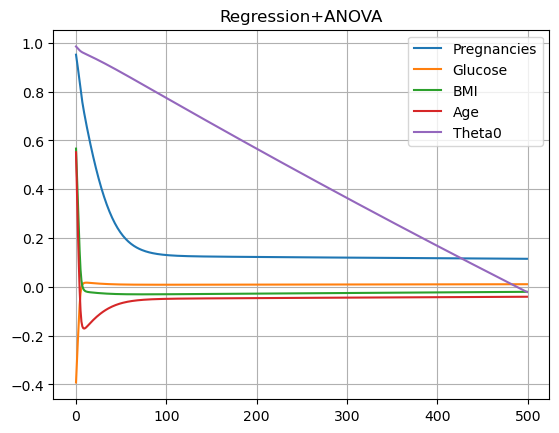

In [68]:
labels_new = selecteur.transform(np.array(diabetes.columns[:-1]).reshape(1, len(diabetes.columns)-1)).flatten()

for i in range(len(labels_new)): 
    plt.plot(range(MAX_IT), coefs_anova[:, i], label=labels_new[i])
plt.plot(range(MAX_IT), coefs0_anova, label="Theta0")
plt.legend()
plt.title("Regression+ANOVA")
plt.grid()
plt.show()

**TODO: Analyser les résultats** 

- Pourquoi la performance de la régression sans filtrage est meilleure dans l'entrainement et pas dans le test; et l'inverse pour la régression avec filtrage ? (P.S. nous ne parlons pas ici du sur-apprentissage; mais des attributs : nombre et qualité)
- Est-ce que le filtrage PEUT prévenir (eviter) le sur-apprentissage ? Si oui, comment ? Si non, pourquoi ?

**Réponse**

- 
    - Entrainement: Le grand nombre d'attribute dans la regression sans ANOVA offre à cette dernière une plus grande fléxibilité (modèle plus complexe) --> le modèle s'addapte beaucoup mieux au données d'entrainement par rapport a regression avec ANOVA qui a moins d'attributs --> moins de fléxibilité 
    - Test: Le modèle sans ANOVA a appris à base de données qui ne sont pas totalement pertinentes (bad quality data), la chose qui a causée une mauvaise performance dans la généralisation. Au contaraire, le modèle avec filtrage ANOVA a appris à base des données pertinentes (good quality data) ce qui a parmit de faire une meilleure généralisation.
- Oui, car le filtrage parmet de ne garder que les features pertinents ce qui va améliorer la qualité des données d'apprentissage et évite d'apprendre à base des donnéees qui ne sont pas pertinente avec la sortie --> on évite le sur-apprentissage.

#### II.2.3. Comparaison entre les différentes approches de sélections d'attributs

Ici, on veut comparer des modèles appartenant à des différentes approches de sélection d'attributs : 
- **ANOVA** : c'est une modèle qui utilise la sélection d'attributs par filtrage. Ici, on prend les attributs qui participent de 50% de la variance (4 attributs dans notre cas)
- **L1** : c'est un modèle qui utilise la sélection d'attributs intégrée (embdded)
- **FFS (Forward Features Selection)** : c'est un modèle qui utilise la sélection d'attributs enveloppante (wrapper). Il commence par tester un seul attribut et ajouter d'autres en validant la solution à chaque fois. Ici, nous avons choisi 4 attributs. 
- **BFE (Backward Features Elimination)** : c'est un modèle qui utilise la sélection d'attributs enveloppante (wrapper). Il commence par tester tous les attributs et éliminer d'autres en validant la solution à chaque fois. Ici, nous avons choisi 4 attributs. 

On veut tester les modèles par rapport à celui sans sélection d'attributs en se basant sur les critères suivants :
- **F1 entrainement** : ici on veut répondre à la question "combien un modèle peut-il converger vers sa solution ?"
- **F1 test** : ici on veut répondre à la question "combien un modèle peut-il généraliser ?"
- **Nombre des itérations** : ici on veut répondre à la question "combien faut-il d'itérations pour qu'un modèle converge ?"
- **Temps pré-entrainement** : ici on veut répondre à la question "combien de temps faut-il pour préparer les attributs avant l'entrainement ?"
- **Temps entrainement** : ici on veut répondre à la question "combien de temps faut-il pour l'entrainement ?"

*P.S. L'exécution prend un peu de temps*


In [72]:
from sklearn.feature_selection import SequentialFeatureSelector
import timeit

CMAX_ITER = 5000
creglog       = LogisticRegression(penalty=None, solver="saga", max_iter=CMAX_ITER)
creglog_l1    = LogisticRegression(penalty='l1', solver="saga", max_iter=CMAX_ITER)
creglog_anova = LogisticRegression(penalty=None, solver="saga", max_iter=CMAX_ITER)
creglog_ffs   = LogisticRegression(penalty=None, solver="saga", max_iter=CMAX_ITER)
creglog_bfe   = LogisticRegression(penalty=None, solver="saga", max_iter=CMAX_ITER)

temps   = {}
temps_p = {}

# Regression logistique normale
# ==============================
temps_debut = timeit.default_timer()
creglog.fit(X_train, Y_train)
temps["reg"] = timeit.default_timer() - temps_debut
# ===============================


# Regression logistique avec L1
# ===============================
temps_debut = timeit.default_timer()
creglog_l1.fit(X_train, Y_train)
temps["l1"] = timeit.default_timer() - temps_debut
# ===============================

# Regression logistique normale sur les 
# caracteristiques selectionnees par ANOVA
# ===============================
# Selection d'attributs avant l'antrainement
temps_debut = timeit.default_timer()
selecteur_anova = SelectPercentile(score_func=f_classif, percentile=50)
X_train_anova = selecteur.fit_transform(X_train, Y_train)
temps_p["anova"] = timeit.default_timer() - temps_debut
X_test_anova = selecteur.transform(X_test)
# Entrainement de la regression logistique sur les caracteristiques selectionnees
temps_debut = timeit.default_timer()
creglog_anova.fit(X_train_anova, Y_train)
temps["anova"] = timeit.default_timer() - temps_debut
# ===============================

# Regression logistique normale sur les 
# caracteristiques selectionnees par FFS
# ===============================
# Selection d'attributs avant l'antrainement
temps_debut = timeit.default_timer()
selecteur_ffs = SequentialFeatureSelector(creglog_ffs, n_features_to_select=4, direction="forward")
X_train_ffs = selecteur_ffs.fit_transform(X_train, Y_train)
temps_p["ffs"] = timeit.default_timer() - temps_debut
X_test_ffs = selecteur_ffs.transform(X_test)
# Entrainement de la regression logistique sur les caracteristiques selectionnees
temps_debut = timeit.default_timer()
creglog_ffs.fit(X_train_ffs, Y_train)
temps["ffs"] = timeit.default_timer() - temps_debut
# ===============================

# Regression logistique normale sur les 
# caracteristiques selectionnees par BFE
# ===============================
# Selection d'attributs avant l'antrainement
temps_debut = timeit.default_timer()
selecteur_bfe = SequentialFeatureSelector(creglog_bfe, n_features_to_select=4, direction="backward")
X_train_bfe = selecteur_bfe.fit_transform(X_train, Y_train)
temps_p["bfe"] = timeit.default_timer() - temps_debut
X_test_bfe = selecteur_bfe.transform(X_test)
# Entrainement de la regression logistique sur les caracteristiques selectionnees
temps_debut = timeit.default_timer()
creglog_bfe.fit(X_train_bfe, Y_train)
temps["bfe"] = timeit.default_timer() - temps_debut
# ===============================

pd.DataFrame({
    "Criteres" : ["F1 Entrainement", 
                  "F1 Test", 
                  "Nombre des itérations", 
                  "temps pré-entrainement", 
                  "temps entrainement"],
    "Reg"      : [f1_score(Y_train, creglog.predict(X_train)), 
                  f1_score(Y_test, creglog.predict(X_test)),
                  creglog.n_iter_, 
                  0, 
                  temps["reg"]],
    "Reg+L1"   : [f1_score(Y_train, creglog_l1.predict(X_train)), 
                  f1_score(Y_test, creglog_l1.predict(X_test)), 
                  creglog_l1.n_iter_, 
                  0, 
                  temps["l1"]],
    "ANOVA+Reg": [f1_score(Y_train, creglog_anova.predict(X_train_anova)), 
                  f1_score(Y_test, creglog_anova.predict(X_test_anova)), 
                  creglog_anova.n_iter_, 
                  temps_p["anova"], 
                  temps["anova"]],
    "FFS"      : [f1_score(Y_train, creglog_ffs.predict(X_train_ffs)), 
                  f1_score(Y_test, creglog_ffs.predict(X_test_ffs)), 
                  creglog_ffs.n_iter_, 
                  temps_p["ffs"], 
                  temps["ffs"]],
    "BFE"      : [f1_score(Y_train, creglog_bfe.predict(X_train_bfe)), 
                  f1_score(Y_test, creglog_bfe.predict(X_test_bfe)), 
                  creglog_bfe.n_iter_, 
                  temps_p["bfe"], 
                  temps["bfe"]],
})

,Criteres,Reg,Reg+L1,ANOVA+Reg,FFS,BFE
0,F1 Entrainement,0.465574,0.465574,0.382671,0.567568,0.585526
1,F1 Test,0.393443,0.380165,0.37931,0.564516,0.539683
2,Nombre des itérations,[1407],[1404],[177],[5000],[5000]
3,temps pré-entrainement,0,0,0.001309,11.065433,20.632152
4,temps entrainement,0.100739,0.123936,0.009283,0.238099,0.242543


**TODO: Analyser les résultats** 

- Pourquoi la sélection d'attributs envelopante prend plus de temps d'entrainement pourtant elle utilise moins d'attributs ? (en se basant sur les résultats)
- Pourquoi la régression avec L1 prend plus de temps d'entrainement que la régression normale pourtant elle prend moins d'itérations ?
- Pourquoi la sélection d'attributs enveloppante donne des performances mieux que celle par filtrage pourtant cette dernière sélectionne les meilleurs attributs en terme de corrélation ? (dans notre cas, c'est le même nombre d'attributs = 4)
- Si vous avez un dataset avec plusieurs attributs et une quantité énorme d'échantillons, proposer une solution avec moins de temps de pré-entrainement+entrainement et plus de performance (par rapport la solution sans sélection d'attributs) en se basant sur les résultats de cette expérimentation.

**Réponse**

- l'approche enveloppante a pris plus de temps durant l'entrainement à cause du fait que la selection d'attribut pertinant a rendu le minimum de la fonction erreur plus long à atteindre potentiellement à cause du fait que la foncion erreur a un minimum plus bas ou une forme moins raide.
- A cause de la complexité de la fonction objectif dans chaque itération dans la régression avec L1.
- Le filtrage avec ANOVA selectionne les attributs individuellemnt tendis que l'approche enveloppante prend en considération les interractions entres les attributs.
- Dans le cas de grande quantité de donné, il faut éviter FFS et BFE car le temps de préentrainement va etre tres important, la solution recommedé serait d'utiliser ANOVA car cette derniere va au contraire beneficier du big data car la F-statistique va etre plus puissante (plus precise) --> meilleure selection d'attribut -> bonne performance sans overhead of pretraining and training